# Raster data

## Introduction 

Raster is a type of geo-referenced data that represents phenomena occurring continuously on (or relative to) the surface of the Earth. A common example of data stored in raster format is elevation, but many other phenomena are recorded in the same way. Today many sensors orbit the Earth on board of satellites, they all collect data in raster form.

The earliest examples of raster data where aerial photograms that were transformed into digital format. The photograph would become a matrix of geo-referenced values - the raster. 

![Aerial photograph](https://upload.wikimedia.org/wikipedia/commons/7/78/Podgorica_1999_Kosovo_War.jpg)
*Image from [Wikipaedia](https://en.wikipedia.org/wiki/Aerial_photography#/media/File:Podgorica_1999_Kosovo_War.jpg)*

![Satellite image](https://miro.medium.com/max/315/1*ibilH1kPEWujNaUhwM5ezA.jpeg)
*Satellite image from [Sentinel Hub](https://www.sentinel-hub.com/blog/building-added-value-services-top-sentinel-hub)*

![Digital Elevation Model](https://gisgeography.com/wp-content/uploads/2016/04/DEM-Sources-2-678x322.png)
*Digital Elevation Model from [GISGeography.com](https://gisgeography.com/free-global-dem-data-sources/)*

A raster captures a continuous phenomenon into a ***regular tessellation*** of space. Within each tile or cell of the raster the phenomenon or variable is represented as constant. The location and size of each cell is perfectly known since the tessellation is regular. This process of collecting a continuous variable into a raster is sometimes referred to as ***discretisation***.

![Raster](https://camo.githubusercontent.com/bf207b7f1a4bc70ae8cf652921320c6ff3a0e280/687474703a2f2f6c65732d656a6b2e637a2f736b6f6c656e692f67726173732f75766f642f5f696d616765732f7261737465722d64657461696c2d64657461696c2e706e67)
*A matrix of values composing a raster*

As many satellites carry various sensors on board, often raster files represent more than one phenomenon or variable. In essence, it is composed by more than one overlapping matrices. These individual matrices are known as ***bands***.

![Raster bands](https://www.neonscience.org/sites/default/files/images/dc-spatial-raster/RGBSTack_1.jpg)
*Three visible bands from a satellite can be combined into a colour image. Source: [Neon Science](https://www.neonscience.org/dc-multiband-rasters-r)*

## Tools

[GDAL](https://gdal.org/) is today the reference toolbox to read and write raster data. It is used by almost all of the FOSS4G programmes and libraries that interact with rasters. GDAL is also used by many commercial products. A [Python API](https://gdal.org/python/) is available for GDAL that provides much of the functionality.

The [RasterIO](https://rasterio.readthedocs.io) library makes interaction with rasters considerably more convenient, however. It is in essence a bridge between GDAL and the [NumPy](https://numpy.org/) package for scientific computing. With RasterIO rasters are easily translated into NumPy arrays and vice-versa.

## Reading in and inspecting a raster

Possibly the most essential operation is to open a raster for processing or inspection. This is rather simple:



In [1]:
import numpy as np
import rasterio

In [2]:
srtm = rasterio.open('../data/srtm/srtm.geotiff')

This is a tile from the digital elevation model produced by the [Shuttle Radio Topography Mission](https://www2.jpl.nasa.gov/srtm/). 

The `open` method returns an object of the class `DatasetReader`, which contains the raster meta-data and the set of bands included. `open` can also be invoked in write (with the extra argument `'w'`, in which case it returns a `DatasetWriter` type object.

`DatasetReader` provides easy access to useful meta-data, for instance its dimensions:

In [ ]:
srtm.width

In [ ]:
srtm.height

Also information related to the reader object itself:

In [ ]:
srtm.name

In [ ]:
srtm.mode

In [ ]:
srtm.meta

In [ ]:
srtm.shape

The `count` property informs on the number of bands:

In [ ]:
srtm.count

Data types of bands are provided with `dtypes`:

In [ ]:
srtm.dtypes

The geographic information is also available:

In [ ]:
srtm.crs

In [ ]:
srtm.bounds

The `read` method provides the means to actually access the information in the raster. It takes as argument the band number and returns a NumPy [NDArray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) object:

In [3]:
srtm_array = srtm.read(1)
srtm_array

array([[346, 347, 348, ..., 402, 403, 403],
       [345, 351, 357, ..., 399, 402, 402],
       [360, 367, 374, ..., 410, 414, 410],
       ..., 
       [257, 256, 259, ..., 460, 456, 452],
       [277, 269, 265, ..., 453, 450, 449],
       [305, 308, 302, ..., 443, 441, 446]], dtype=int16)

## Basic raster plotting

In [ ]:
world = rasterio.open('../data/world.rgb.tif')

We can display the raster with a single line:

In [ ]:
%matplotlib inline
from rasterio import plot
plot.show(world)

We can also display a single band of a multiband image by passing a tuple (raster source, band):

In [ ]:
plot.show((world, 2), cmap='viridis')

Multiple bands side by side:

In [ ]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
plot.show((world, 1), ax=axr, cmap='Reds', title='red channel')
plot.show((world, 2), ax=axg, cmap='Greens', title='green channel')
plot.show((world, 3), ax=axb, cmap='Blues', title='blue channel')

If we want to see a histogram of the data we use the `plot.show_hist` function:

In [ ]:
%matplotlib inline
plot.show_hist(world)

Any of the optional `pyplot` histogram parameters can be passed to tweak the representation:

In [ ]:
plot.show_hist(world, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="World Histogram overlaid")

Show contours from a raster:

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show((world, 1), cmap='Greys_r', interpolation='none', ax=ax)
ax.set_xlim(-50, 0)
ax.set_ylim(0, 40)

plot.show((world, 1), contour=True, ax=ax)

## Creating a new raster

With a raster band encapsulated into an array, map algebra and analysis in general become rather simple. As an example, consider the high pass filter defined by the moving window below:

![High-pass filter](./images/HighPassFilter.png)

This is a typical operation in digital imaging processing that also finds application in raster analysis. Applying this moving window to a NumPy array requires the following:

In [4]:
import numpy as np
high_pass_array = np.full(srtm_array.shape, 0).astype(np.int16)

for i in range (1, srtm_array.shape[0] - 1):
    for j in range (1, srtm_array.shape[1] - 1):
        high_pass_array[i,j] = \
            srtm_array[i,j] * 4 - \
            srtm_array[i-1,j] - \
            srtm_array[i,j+1] - \
            srtm_array[i,j-1] - \
            srtm_array[i+1,j]
            
high_pass_array

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, -12,  -5, ..., -15, -10,   0],
       [  0,   3,  12, ...,   7,  15,   0],
       ..., 
       [  0, -59, -52, ...,   9,   6,   0],
       [  0, -30, -24, ...,   4,   1,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int16)

Since this is a NumPy Array object, it can be plotted with [matplotlib](https://matplotlib.org). This library is meant for Maths but it works rather smootly with rasters too. This is a means to inspect intermidiary results.

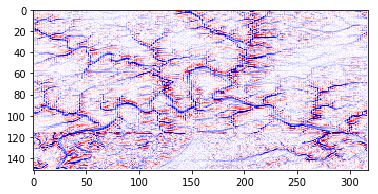

In [6]:
from matplotlib import pyplot
pyplot.imshow(high_pass_array, cmap='seismic')
pyplot.show()

The high pass filter highlights transitions (the blue and red cells in the raster above). Since the input is a DEM, in this case the high pass filter shows the cells with steepest slope.

This new raster is still just an array. In order to save it (or use it in general) as a geo-referenced object, a new `Dataset` object must be created. This can be made with the `open` method in write mode, i.e. using the `'w'` argument:

In [11]:
high_pass = rasterio.open(
    '../data/srtm/srtm_high_pass.geotiff',
    'w',
    driver='GTiff',
    height=high_pass_array.shape[0],
    width=high_pass_array.shape[1],
    count=1,
    dtype=str(high_pass_array.dtype),
    crs=srtm.crs,
    transform=srtm.transform
)

In write mode `open` needs some more information. The number of rows and columns, plus the data type, are passed from the array object itself. The CRS information is obtained from the original `srtm` object. Only the content of the cells in the new raster is different, the location and size remain the same. 

`open` created a connection to a new raster file and returned an object of type `RasterUpdater`. With this object the contents of the new array can be copied into the file:


In [13]:
high_pass.write(high_pass_array, 1)

The `write` method takes as arguments the NumPy array with the cell contents and the band number in the raster. In this case `1` is used for the band number, as there is only one.

The flush the file into the hard disk the `close` method is used:

In [14]:
high_pass.close()

---
[<- Vector data](04-vector-data.ipynb) | [Data analysis ->](06-data-analysis.ipynb)